In [21]:
import re
from collections import Counter
import matplotlib.pyplot as plt

# Đọc dữ liệu từ file
with open("/content/demo-full.txt", 'r', encoding='utf-8') as f:
    text = f.read()


# Tiền xử lý văn bản
def preprocess_text(text):
    text = text.lower()  # Chuyển thành chữ thường
    # Giữ lại các chữ cái tiếng Việt và khoảng trắng, loại bỏ các ký tự đặc biệt khác
    text = re.sub(r'[^a-zA-Zàáảãạăằắẳẵặâầấẩẫậèéẻẽẹêềếểễệìíỉĩịòóỏõọôồốổỗộơờớởỡợùúủũụưừứửữựỳýỷỹỵđ\s]', '', text)

    sentences = re.split(r'[.!?]', text)  # Tách câu
    sentences = ['<s> ' + sentence.strip() + ' </s>' for sentence in sentences if sentence.strip()]
    return sentences

processed_sentences = preprocess_text(text)

# Tách từ
tokens = [word for sentence in processed_sentences for word in sentence.split()]



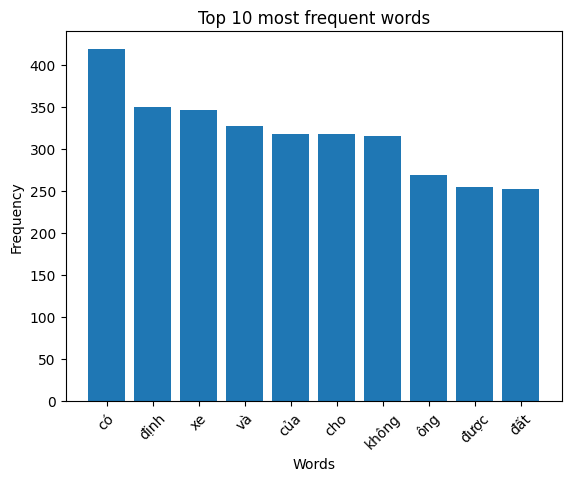

In [22]:
# Tạo vocab và tính tần suất
vocab = Counter(tokens)

# Vẽ đồ thị tần suất của 10 từ xuất hiện nhiều nhất
top_10_words = vocab.most_common(10)

words, counts = zip(*top_10_words)
plt.bar(words, counts)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 most frequent words')
plt.xticks(rotation=45)
plt.show()


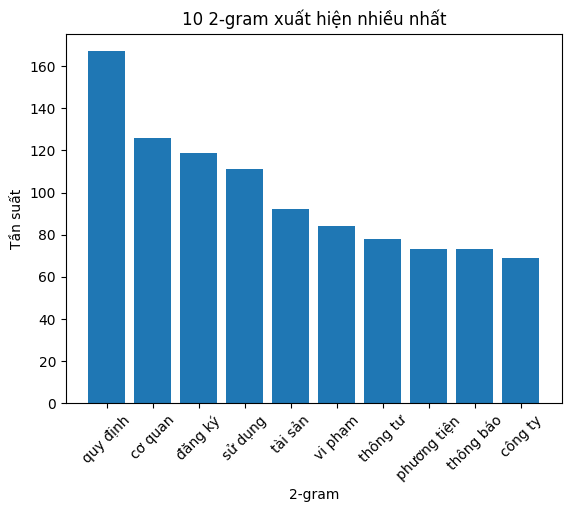

In [23]:
# Tính tần suất 2-gram
bigrams = [(tokens[i], tokens[i + 1]) for i in range(len(tokens) - 1)]
bigram_freq = Counter(bigrams)

# Vẽ đồ thị cột cho 10 2-gram xuất hiện nhiều nhất
most_common_bigrams = bigram_freq.most_common(10)
bigram_labels, bigram_counts = zip(*most_common_bigrams)

# Chuyển đổi 2-gram thành chuỗi để dễ hiển thị
bigram_labels = [' '.join(bigram) for bigram in bigram_labels]

plt.bar(bigram_labels, bigram_counts)
plt.xticks(rotation=45)
plt.xlabel('2-gram')
plt.ylabel('Tần suất')
plt.title('10 2-gram xuất hiện nhiều nhất')
plt.show()


In [5]:
# Tính xác suất có điều kiện của 2-gram
conditional_probs = {}
for (w1, w2), freq in bigram_freq.items():
    conditional_probs[(w1, w2)] = freq / vocab[w2]

# Ví dụ: in ra xác suất của một số 2-gram
for (w1, w2) in list(conditional_probs.keys())[:5]:
    print(f"P({w1}|{w2}) = {conditional_probs[(w1, w2)]:.4f}")


P(<s>|chây) = 0.2500
P(chây|ì) = 1.0000
P(ì|nộp) = 0.0328
P(nộp|phạt) = 0.2300
P(phạt|nguội) = 1.0000


In [6]:
import random

def suggest_next_word(input_text):
    words = input_text.split()
    if len(words) < 1:
        return []

    last_word = words[-1]
    suggestions = [w1 for (w1, w2) in conditional_probs.keys() if w2 == last_word]
    return random.choices(suggestions, k=5)  # Gợi ý 5 từ

# Ví dụ gợi ý từ
input_text = "bạn đang mong muốn sử dụng đất"
suggestions = suggest_next_word(input_text)
print("Gợi ý từ:", suggestions)


Gợi ý từ: ['liệu', 'khoán', 'việc', 'mảnh', 'tờ']


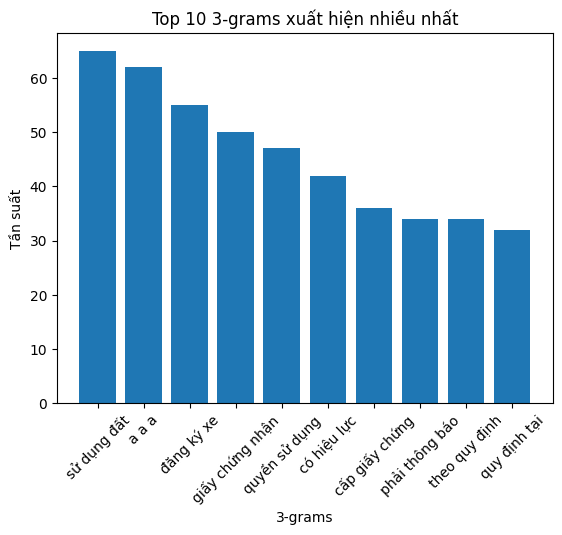

In [31]:
# Tính tần suất 3-gram
trigrams = [(tokens[i], tokens[i + 1], tokens[i + 2]) for i in range(len(tokens) - 2)]
trigram_freq = Counter(trigrams)
top_10_trigram = trigram_freq.most_common(10)
trigram_words, trigram_counts = zip(*top_10_trigram)
bigram_labels = [f'{w1} {w2} {w3}' for w1, w2,w3 in trigram_words]
plt.bar(bigram_labels, trigram_counts)
plt.xticks(rotation=45)
plt.xlabel('3-grams')
plt.ylabel('Tần suất')
plt.title('Top 10 3-grams xuất hiện nhiều nhất')
plt.show()


In [32]:
# Tính xác suất có điều kiện của 3-gram
conditional_probs_3gram = {}
for (w1, w2, w3), freq in trigram_freq.items():
    conditional_probs_3gram[(w1, w2, w3)] = freq / bigram_freq[(w1, w2)]

# Gợi ý từ mới dựa trên 2 từ cuối
def suggest_next_word_3gram(input_text):
    words = input_text.split()
    if len(words) < 2:
        return []

    last_two_words = (words[-2], words[-1])
    suggestions = [w3 for (w1, w2, w3) in conditional_probs_3gram.keys() if (w1, w2) == last_two_words]
    return random.choices(suggestions, k=5)  # Gợi ý 5 từ


# Ví dụ gợi ý từ cho mô hình 3-gram
input_text_3gram = "bạn đang mong muốn sử dụng đất"
suggestions_3gram = suggest_next_word_3gram(input_text_3gram)
print("Gợi ý từ 3-gram:", suggestions_3gram)


Gợi ý từ 3-gram: ['quyền', 'thuộc', 'chủ', 'đối', 'trước']


In [8]:
!pip install keras


In [9]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Dữ liệu giả lập cho ví dụ (thay 'processed_sentences' bằng dữ liệu thực tế của bạn)
# Giới hạn số từ tối đa và độ dài chuỗi tối đa
MAX_NUM_WORDS = 100000
MAX_SEQUENCE_LENGTH = 50

# Khởi tạo tokenizer với số từ tối đa
tokenizer = Tokenizer()
tokenizer.fit_on_texts(processed_sentences)

# Chuyển đổi câu thành sequences, chỉ bao gồm các từ trong giới hạn
sequences = tokenizer.texts_to_sequences(processed_sentences)

# Tạo dữ liệu đầu vào và nhãn
X = []
y = []

for seq in sequences:
    for i in range(1, len(seq)):
        X.append(seq[:i])  # Các từ trước từ cần dự đoán
        y.append(seq[i])   # Từ cần dự đoán

# Padding để tất cả các sequence đều có chiều dài giống nhau
X = pad_sequences(X, padding='pre', maxlen=MAX_SEQUENCE_LENGTH)

# Chuyển đổi y thành mảng NumPy thay vì one-hot encoding
y = np.array(y)  # y chỉ chứa các giá trị số nguyên, không one-hot



In [10]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

# Xây dựng mô hình
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=X.shape[1]))
model.add(LSTM(100))
model.add(Dense(len(tokenizer.word_index) + 1, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [11]:
model.fit(X, y, epochs=50, batch_size=64)


Epoch 1/50
514/514 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.0116 - loss: 6.6851
Epoch 2/50
514/514 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.0267 - loss: 6.1584
Epoch 3/50
514/514 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.0809 - loss: 5.7335
Epoch 4/50
514/514 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1453 - loss: 5.2106
Epoch 5/50
514/514 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1965 - loss: 4.7814
Epoch 6/50
514/514 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.2380 - loss: 4.4112
Epoch 7/50
514/514 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.2750 - loss: 4.1041
Epoch 8/50
514/514 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.3057 - loss: 3.8718
Epoch 9/50
514/514 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.3292 - loss: 3.6520
Epoch 10/50
514/514 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.3560 - loss: 3.4708
Epoch 11/50
514/514 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.3725 - loss: 3.3251
Epoch 12/50
514/514 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/ste

In [12]:
def suggest_next_word_lstm(input_text):
    sequence = tokenizer.texts_to_sequences([input_text])[0]
    sequence = pad_sequences([sequence], maxlen=X.shape[1], padding='pre')

    predicted = model.predict(sequence, verbose=0)
    top_indices = predicted[0].argsort()[-10:][::-1]  # Lấy 10 chỉ số lớn nhất để tạo sự đa dạng
    top_words = [tokenizer.index_word[i] for i in top_indices if i > 0]  # Trả về từ tương ứng

    # Lấy ngẫu nhiên 5 từ trong các từ có chỉ số lớn nhất
    random_top_words = random.sample(top_words, min(len(top_words), 5))
    return random_top_words

# Ví dụ gợi ý từ
input_text_lstm = "bạn đang mong muốn sử dụng đất"
suggestions_lstm = suggest_next_word_lstm(input_text_lstm)
print("Gợi ý từ LSTM:", suggestions_lstm)


Gợi ý từ LSTM: ['đai', 'về', 'cũ', 'như', 'cụ']


In [13]:
def suggest_word_system(input_text):
    words = input_text.split()
    suggestions = []

    # Sử dụng mô hình n-gram nếu chuỗi đầu vào có từ 1-5 từ
    if len(words) <= 5:
        if len(words)>= 1<=2:
            suggestions = suggest_next_word(input_text)  # Dùng 2-gram cho 1 từ cuối
        elif len(words) >= 3:
            suggestions = suggest_next_word_3gram(input_text)  # Dùng 3-gram cho 2 từ cuối
    else:
        # Sử dụng mô hình LSTM nếu chuỗi đầu vào có trên 5 từ
        lstm_suggestions = suggest_next_word_lstm(input_text)
        suggestions.extend(lstm_suggestions)

        # Thêm một từ gợi ý từ mô hình 2-gram
        bigram_suggestion = suggest_next_word(input_text)
        if bigram_suggestion:
            suggestions.append(bigram_suggestion[0])  # Chỉ lấy 1 từ gợi ý từ 2-gram

    # Loại bỏ từ trùng lặp trong danh sách gợi ý
    suggestions = list(set(suggestions))
    return suggestions if suggestions else ["Không có gợi ý từ"]

# Ví dụ sử dụng hàm gợi ý từ với đầu vào của người dùng
user_input = "chào bạn"
suggestions_result = suggest_word_system(user_input)
print("Gợi ý từ từ hệ thống:", suggestions_result)


Gợi ý từ từ hệ thống: ['hn', 'bố', 'mẹ', 'ban', 'từ']


In [14]:
!pip install ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.3 MB/s eta 0:00:00


In [18]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Widget ô nhập văn bản
input_box = widgets.Text(
    value='',
    placeholder='Nhập văn bản...',
    description='Văn bản:',
    disabled=False,
    layout=widgets.Layout(width='100%')  # Đặt kích thước
)

# Widget khu vực đầu ra
output_area = widgets.Output()

# Widget danh sách gợi ý
suggestions_box = widgets.VBox([])  # Sử dụng VBox để chứa danh sách gợi ý

# Hàm cập nhật gợi ý dựa trên văn bản đầu vào
def on_text_change(change):
    with output_area:
        clear_output()
        user_input = change['new']
        suggestions = suggest_word_system(user_input)  # Giả sử hàm này trả về danh sách các gợi ý
        update_suggestions(suggestions)

# Hàm cập nhật danh sách gợi ý
def update_suggestions(suggestions):
    # Xóa danh sách gợi ý hiện tại
    suggestions_box.children = []

    for suggestion in suggestions:
        button = widgets.Button(description=suggestion)
        button.on_click(lambda b, text=suggestion: on_suggestion_click(text))
        suggestions_box.children += (button,)

# Hàm cập nhật ô nhập văn bản khi chọn gợi ý
def on_suggestion_click(suggestion):
    # Chèn từ gợi ý vào cuối văn bản hiện tại
    input_box.value += suggestion + ' '  # Thêm gợi ý và khoảng trắng

# Gán hàm cập nhật gợi ý khi văn bản đầu vào thay đổi
input_box.observe(on_text_change, names='value')

# Hiển thị ô nhập văn bản, khu vực đầu ra và danh sách gợi ý
display(input_box)
display(suggestions_box)
display(output_area)


Text(value='', description='Văn bản:', layout=Layout(width='100%'), placeholder='Nhập văn bản...')

VBox()

Output()